In [26]:
import shutil
import os
import networkx as nx
import numpy as np

from matplotlib import pyplot as plt
from scipy.integrate import odeint

In [27]:
def get_toy_graph(which='simplest'):
    '''
    Returns networkx object of toy examples to test model on. 
    
    which: Choose which toy example to return. Can be one of 'simplest', 'simple', 'feedback', 'multiple_regulation'
    and 'multiple_regulation_feedback'.
    '''
    G = nx.DiGraph()
    
    # May the gods of programming languages forgive me for this shitty code.
    if which == 'simplest':
        G.add_edge('TF', 'gene1', weight=0.8)
        G.add_edge('TF', 'gene2', weight=-1.2)
    elif which == 'simple':
        G.add_edge('TF1.1', 'TF2.1', weight=0.8)
        G.add_edge('TF1.1', 'TF2.2', weight=-1.2)
        G.add_edge('TF2.1', 'gene1', weight=1.5)
        G.add_edge('TF2.1', 'gene2', weight=-0.4)
        G.add_edge('TF2.2', 'gene3', weight=0.9)
        G.add_edge('TF2.2', 'gene4', weight=-2.2)
    elif which == 'feedback':
        G.add_edge('TF1.1', 'TF2.1', weight=0.8)
        G.add_edge('TF1.1', 'TF2.2', weight=1.2)
        G.add_edge('TF2.1', 'gene1', weight=1.5)
        G.add_edge('TF2.1', 'gene2', weight=-0.4)
        G.add_edge('TF2.2', 'gene3', weight=0.9)
        G.add_edge('TF2.2', 'gene4', weight=-2.2)
        G.add_edge('TF2.2', 'TF1.1', weight=-1.5) # Feedback.
    elif which == 'multiple_regulation':
        G.add_edge('TF1.1', 'TF2.1', weight=0.8)
        G.add_edge('TF1.1', 'TF2.2', weight=1.2)
        G.add_edge('TF2.1', 'gene1', weight=1.5)
        G.add_edge('TF2.1', 'gene2', weight=-0.4)
        G.add_edge('TF2.2', 'gene3', weight=0.9)
        G.add_edge('TF2.2', 'gene4', weight=-2.2)
        G.add_edge('TF2.2', 'gene2', weight=-0.7)
        G.add_edge('TF2.1', 'gene3', weight=-0.7)
    elif which == 'multiple_regulation_feedback':
        G.add_edge('TF1.1', 'TF2.1', weight=0.8)
        G.add_edge('TF1.1', 'TF2.2', weight=1.2)
        G.add_edge('TF2.1', 'gene1', weight=1.5)
        G.add_edge('TF2.1', 'gene2', weight=-0.4)
        G.add_edge('TF2.2', 'gene3', weight=0.9)
        G.add_edge('TF2.2', 'gene4', weight=-2.2)
        G.add_edge('TF2.2', 'gene2', weight=-0.7)
        G.add_edge('TF2.1', 'gene3', weight=-0.7)
        G.add_edge('gene3', 'TF1.1', weight=-0.5)
    return G

def discretize_edges(G):
    '''
    Takes a graph with edge weights and turns it into the discretized
    version, where edges are {-1,0, 1}.
    
    returns: networkx DiGraph with discretized weight.
    '''
    H = G.copy()
    for u,v,d in H.edges(data=True):
        d['weight'] = np.sign(d['weight'])
    return H

def split_adj_matrix(A):
    '''
    Takes in matrix of 1 and -1 and returns two matrices
    '''
    Aa = np.array((A.toarray() == 1), dtype = 'int32') # Consider making this float64 instead.
    Ai = np.array((A.toarray() == -1), dtype = 'int32')
    return Aa, Ai

In [28]:
def visualize(G, node_color='k'):
    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())

    pos = nx.spring_layout(G, weight=None) # get edge positions
    #pos = nx.graphviz_layout(G)
    nx.draw(G, pos, node_color=node_color, edgelist=edges,
            edge_color=weights, node_cmap=plt.cm.coolwarm, 
            edge_cmap=plt.cm.coolwarm)
    # May want to try other colormaps.
    plt.show()

In [30]:

def visualize_timecourse(G, time_course, pos=None, name="graph"):
    '''
    Visualizes the timecourse data. Careful with "name", this function will remove
    any directory with that name and replace it with the current simulation.
    '''
    def normalize(time_course):
        '''
        Normalizes input array so values are in [-1, 1].
        '''
        positive = (time_course > 0) * time_course
        negative = (time_course <= 0) * time_course
        return positive / np.max(positive) + negative / np.abs(np.min(negative))
    if os.path.exists(name):
        shutil.rmtree(name) # Remove current directory if it exists.
    os.makedirs(name)

    if pos == None:
        pos = nx.spring_layout(G, weight=None) # get edge positions
    
    time_course = normalize(time_course)
    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
    
    
    for i in range(time_course.shape[0]):
        plt.figure()
        nx.draw_networkx_nodes(G, pos, node_color=time_course[i,:], 
                               cmap=plt.cm.coolwarm, vmin=-1, vmax=1)

        nx.draw_networkx_edges(G, pos, edgelist=edges, 
                               edge_color=weights, cmap=plt.cm.coolwarm,
                               vmin=-2.5, vmax=2.5)
        plt.savefig(name + "/" + f"{i}" + ".png")
        plt.close()

In [31]:
def f(y, t0, A, u, kf):
    return (A - kf * np.identity(len(A))) @ y + u

In [52]:
def simulate_and_plot(G, kf=0.5, u=None, pos=None, name='graph',
                      times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80])):
    A = nx.adjacency_matrix(G)
    A = A.toarray()
    A = A.transpose()
    
    if pos is None:
        pos = nx.spring_layout(G, weight=None) # get edge positions

    if u is None:
        u = np.array([1.0] + [0.0] * (len(A) - 1))
    
    y0 = [0.0] * len(A)
    
    
    y = odeint(f, y0=y0,
               t=times,
               args=(A, u, kf))
    visualize_timecourse(G, y, pos=pos, name=name)

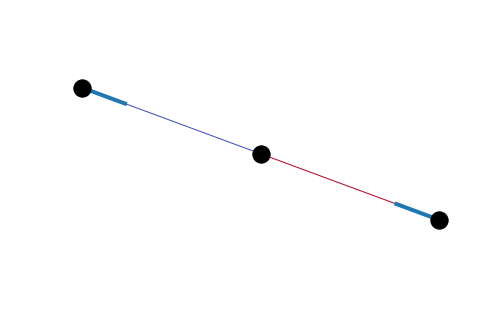

In [53]:
G = get_toy_graph('simplest')

visualize(G)

In [34]:
simulate_and_plot(G, name='graph2')

In [39]:
times = np.array(range(8)) * 2
times

array([ 0,  2,  4,  6,  8, 10, 12, 14])

In [54]:
for name in ['simplest', 'simple', 'feedback', 'multiple_regulation', 'multiple_regulation_feedback']:
    G = get_toy_graph(name)
    pos = nx.spring_layout(G, weight=None) # get edge positions
    simulate_and_plot(G, pos=pos, name=name,
                     times=times)
    H = discretize_edges(G)
    simulate_and_plot(H, pos=pos, name=name+'_discrete',
                     times=times)

In [47]:
pos

{'TF1.1': array([-0.09624631,  0.01012123]),
 'TF2.1': array([-0.15991545,  0.34512777]),
 'TF2.2': array([ 0.00405986, -0.31596908]),
 'gene1': array([ 0.21543697,  0.67358436]),
 'gene2': array([-0.68642769,  0.30291859]),
 'gene3': array([ 0.06321372, -0.01578287]),
 'gene4': array([ 0.6598789, -1.       ])}